In [1]:
# Import stuff we'll need later
import numpy as np
from scipy.signal import lfilter, lfilter_zi, freqz

%matplotlib inline
import matplotlib.pyplot as plt

Document version 1.1, 2019-12-28

# The Exponential Filter

The [exponential filter](https://en.wikipedia.org/wiki/Exponential_smoothing) is a [low-pass filter](https://en.wikipedia.org/wiki/Low-pass_filter) commonly used due to it's simplicity. It's generally written in the form

$$y_n = \alpha\;x_n+\left(1-\alpha\right)\;y_{n-1}$$

where $\alpha$ is the smoothing factor, $x_n$ is the raw un-filtered signal, $y_n$ is the filtered signal output, and $y_{n-1}$ is the previous output of the filter.

The filter is initialized by simply assigning a raw measurement (or some known value) to the last filtered output.

$$y_0 = x_0$$

Written in Python, the filter might look like the function below.

In [2]:
def expf(xx, y0=0, alpha=1.0):
    yy = np.zeros_like(xx)  # (optional) pre-allocate the output buffer
    yy[0] = y0  # initalize the filter
    
    # Iterate through the input 'xx', note that we start from index 1, not 0
    for ii in range(1, len(xx)):
        yy[ii] = alpha * xx[ii] + (1-alpha) * yy[ii-1]
    return yy

The [time constant](https://en.wikipedia.org/wiki/Time_constant) of an exponential moving average is the amount of time for the filtered output to reach $1-\frac{1}{e}$, or approximatley $0.63\%$ of the input signal. The a filter's time constant can generally be evaluated by analyising its [step response](https://en.wikipedia.org/wiki/Step_response). The relationship between this time constant $\tau$ and the smoothing factor $\alpha$ is given by the formula:

$$\alpha = 1-\exp{\left(\frac{-\Delta T}{\tau}\right)}$$

where $\Delta T$ is the sampling time (inverse of sampling frequency) and $\tau$ is the filter time constant.

Let's quickly check out what this might look like. Let's say that we have a sampling frequency $F_s=100Hz$ and would like to use a time constant of $\tau=2s$.

In [3]:
Fs = 100 # sampling frequency [Hz]
T = 1 / Fs # sampling time [seconds]
tau = 2  # time constant [seconds]
alpha = 1.0 - np.exp(-T/tau)

print('alpha = {:.6f}'.format(alpha))

alpha = 0.004988


If we refer back to the equation for the exponential filter above we can see that the input of the filter $x_n$ is multiplied by the smoothing constant $\alpha$, it is then summed with the complement of alpha $(1-\alpha)$ multiplied by the previous filter output. Intuitively, this means that as the time constant $\tau$ increases, the smoothing factor $\alpha$ decreases, resulting in a smoother output.

## The Exponential Filter as an IIR Filter

The IIR difference equation \([Direct-Form I](https://ccrma.stanford.edu/~jos/filters/Direct_Form_I.html)\) can be written as

$$y_n=\sum_{b_i=0}^{M}b_i\;x_{n-i}-\sum_{j=1}^{N} a_j\;y_{n-j}$$

where $N$ is the feedback filter order, $M$ is the feedforward filter order, and it is assumed that $a_0=1$. Note that the feedback coefficients $\alpha_j$ for $j=1\dots N$ are negative in the equation above.

It can be seen that the exponential is really just a single pole IIR filter where

$$\begin{array}{ccc}a_0 & = & 1 \\ 
a_1 & = & -(1-\alpha) \\
b_0 & = & \alpha \end{array}$$

## Why Does it Matter?

Above we gave an example of how one might implement the exponential filter in Python, it's very simple but has some drawbacks.
    
    - It's slow to execute in pure Python
    - Analysis of the filter is not straight-forward

Seeing as we've bene able to rewrite the filter in the form of a standard IIR it is now much simpler to use and analyize with pre-existing filtering libraries. ne such function is the [*lfilter*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html) function from SciPy.

To represent the exponential filter as an IIR filter all we need are the coefficients, as described above. This leaves us with the following.

In [4]:
b = [alpha] # zeros
a = [1, -(1-alpha)] # poles, a[0] needs to be 1

## Frequency Response

The [frequency response] of a filter tells us how the filter will react to certain input frequencies. More specifically it lets us know how certain frequencies are attenuated or shifted in phase. Using the [*freqz*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html) function from SciPy we can easily view the frequency response of the filter.

In [5]:
# Calculate the frequency response 'h' at the complex frequencies 'w'
# Note that 'w' is returned in the same units as 'Fs'
w, h = freqz(b, a, worN=8192)

w_hz = w * (Fs/(2*np.pi)) # 'convert 'w' from radians to Hz
h_db = 20 * np.log10(np.abs(h)) # convert 'h' from complex magitude to dB
angles = np.unwrap(np.angle(h)) * (180/np.pi)

Text(0, 0.5, 'angle [deg]')

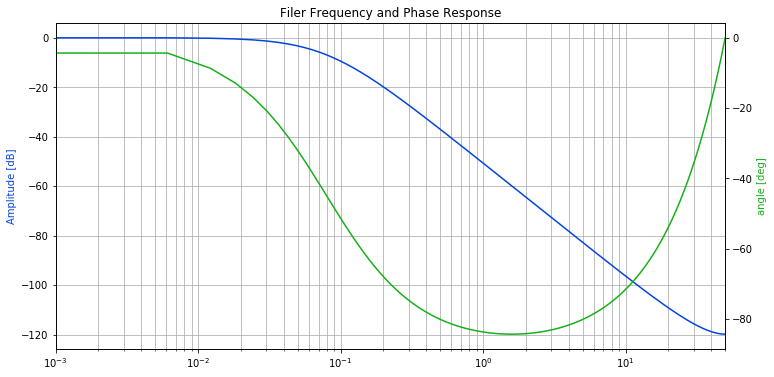

In [6]:
f = plt.figure(figsize=(12, 6))
ax1 = f.add_subplot(111)

ax1.plot(w_hz, 20*np.log(np.abs(h)), color='xkcd:blue')

ax1.set_xscale('log')
ax1.set_xlim([0.001, Fs/2])
ax1.grid(which='both', axis='both')
ax1.set_ylabel('Amplitude [dB]', color='xkcd:blue')
ax1.set_title('Filer Frequency and Phase Response')

ax2 = ax1.twinx()
ax2.plot(w_hz, angles, color='xkcd:green')
ax2.set_ylabel('angle [deg]', color='xkcd:green')

## Step Response

Previously we mentioned [step response](https://en.wikipedia.org/wiki/Step_response) as the key parameter that defined our exponential filter, let's take a look at what that looks like. The [time constant](https://en.wikipedia.org/wiki/Time_constant) of an exponential moving average is the amount of time for the filtered output to reach $1-\frac{1}{e}$, or approximatley $0.63\%$ of the input signal.

To verify that this is the case we need to create a step function and pass it through our filter. In practice this is as simple as creating a set of points that are all $1$'s and passing them through the filter. Let's try that now.

In [7]:
len_s = 10  # signal length [seconds]
xx = np.linspace(0, 10, len_s * Fs, endpoint=False) # define our time series 'xx', as 10 seconds
yy = np.ones_like(xx) # create an array of all 1's for 10 seconds

# Use our previously defined IIR filter constants to filter the signal 'yy'
yy_filt_iir = lfilter(b, a, yy.copy())

# Use our previously defined Exponential filter to filter the signal 'yy'
yy_filt_expf = expf(yy.copy(), y0=0, alpha=alpha)

Above we create the step function '$yy$' as 10 seconds worth of $1$'s sampled at a rate of $100Hz$. We then use the [*lfilter*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html) function to filter the points followed by the previously defined '*expf*' function.

Note that the *lfilter* function does allow you to initialize the filter with the optional function parameter *zi*, but by default the filter is initialized with $0$'s, which happens to work perfectly for us here.

Text(0.5, 1.0, 'IIR and Exponential Filer Step Response')

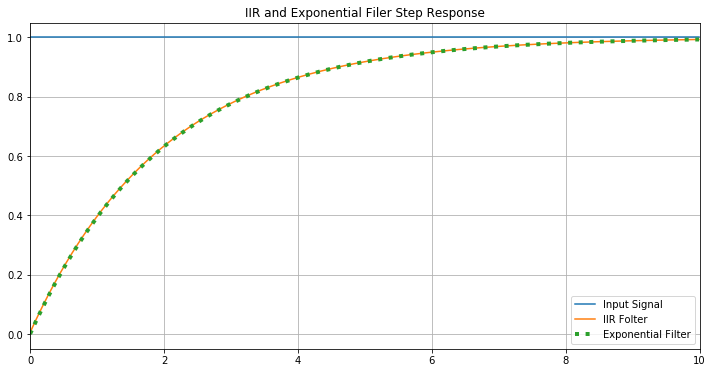

In [8]:
f = plt.figure(figsize=(12, 6))
ax = f.add_subplot(111)

ax.plot(xx, yy, label='Input Signal')
ax.plot(xx, yy_filt_iir, label='IIR Folter')
ax.plot(xx, yy_filt_expf, linewidth = 4, linestyle=':', label='Exponential Filter')

ax.set_xlim([0, len_s])
ax.grid(which='both', axis='both')
ax.legend()
ax.set_title('IIR and Exponential Filer Step Response')

We can see that the filter responses are identical, as expected.

If we were to use the filters on real-world data, we would simply need to replace the input '$yy$' with real data.

## Initial Conditions

With our '*expf*' function it's simple to define the initial condition. If we would like to do the same with the *lfitler* function we need to do a little bit more, here's an example. There's one extra step that has to take to initialize the filter. The [*lfilter_zi*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter_zi.html#scipy.signal.lfilter_zi) function is used to construct the initial conditions for the *lfilter* step response steady-state. Since a step response is the response of the filter to $1$'s, all we need to do is multiply the initial conditions by the value of our desired initial filter value.

Note that below we multiply the steady-state step response of the filter $zi$, with the initial value of our input signal $yy2$.

In [9]:
# Create a new signal
yy2 = 0.5 * np.cos(2*np.pi*0.1*xx) + np.sin(2*np.pi*0.2*xx)

# use the 'lfilter_zi' to choose the filter initial conditions
zi = lfilter_zi(b, a)

# note that 'zi' is multiplied by the first value of 'yy2'
yy2_filt, _ = lfilter(b, a, yy2, zi=zi*yy2[0])

Text(0.5, 1.0, 'IIR Filter with Non-Zero Initial Condition')

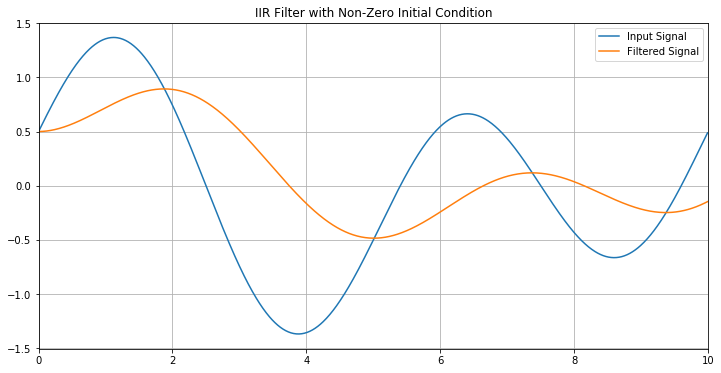

In [10]:
f = plt.figure(figsize=(12, 6))
ax = f.add_subplot(111)

ax.plot(xx, yy2, label='Input Signal')
ax.plot(xx, yy2_filt, label='Filtered Signal')

ax.set_xlim([0, len_s])
ax.grid(which='both', axis='both')
ax.legend()
ax.set_title('IIR Filter with Non-Zero Initial Condition')